# Финальный проект по видеокурсу от MegaFon <a class='anchor' id='begin'>
    
    
Автор: Николай Пахомов ([git](https://github.com/kikoooiemama), [telegram](https://t.me/kikoooiemama), [kaggle](https://www.kaggle.com/kikoooiemama))<br>    

## Содержание
* [Финальный проект по видеокурсу от MegaFon](#begin) 
    * [Задание](#task)
    * [Описание данных](#data_description)
    * [Загрузка библиотек и PATHS](#load_help)
    * [Загрузка данных](#load_data)
    * [1. Анализ данных](#eda)
    * [2. Подготовка и отбор признаков](#data_preparation)
    * [3. Разбиение на train и test](#split)
    * [4. Моделирование](#modeling)
    * [5. Оценка](#evaluation)    
    * [6. Прогнозирование на тестовом датасете](#prediction)

## Задание <a class='anchor' id='task'>

Сформировать персональное предложение абоненту. 

Задание можно решать в 2 этапа: 
<ol>
    <li>Предсказание вероятности подключения услуги</li>
    <li>Формирование индивидуальных предложений и максимизация выручки</li>
</ol>

Иными словами нужно построить алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.

**Целевая переменная**

Target - вероятность подключения услуги пользователем.

**Основная метрика**

Скоринг будет осуществляться функцией *F1-score*, невзвешенным образом. Например, `sklearn.metrics.f1_score(average=’macro’)`.

**Формат представления результата:**

Работающая модель в формате pickle, которая принимает файл data_test.csv из корневой папки и записывает в эту же папку файл answers_test.csv. В этом файле должны находится 4 столбца: buy_time, id, vas_id и target. Target можно записать как вероятность подключения услуги.


## Описание данных <a class='anchor' id='data_description'>

В качестве исходных данных вам будет доступна информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.

Отдельным набором данных будет являться нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.

**Входные данные:**

1. data_train.csv - датасет откликов абонентов на те или иные продукты

    * id - идентификатор абонента,
    * vas_id - подключаемая услуга,
    * buy_time - время покупки, представлено в формате timestamp,
    * target - целевая переменная, где 1 - подключение услуги, 0 - абонент не подключил услугу.


2. features.csv - 
   * id - идентификатор абонента,
   * feature_list - признаки абонента.

**Тестовые данные:**

data_test.csv - датасет откликов абонентов на те или иные продукты

* id - идентификатор абонента,
* vas_id - подключаемая услуга,
* buy_time - время покупки, представлено в формате timestamp.

Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц. 

---
## Загрузка библиотек, скриптов и PATHS <a class='anchor' id='load_help'>

In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import time
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, classification_report, f1_score
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import catboost as catb

import warnings
warnings.filterwarnings('ignore')

In [2]:
RAW_FEATURES_DATASET_PATH = '../data/features.csv'
RAW_TRAIN_DATASET_PATH = '../data/data_train.csv'
RAW_TEST_DATASET_PATH = '../data/data_test.csv'
PREPARED_TRAIN_DATASET_PATH = 'prepared_data/prepared_train_data.csv'
PREPARED_TEST_DATASET_PATH = 'prepared_data/prepared_test_data.csv'
MODEL_PATH = 'models/ctb_model.pickle'
TEST_PREDICTIONS_PATH = 'predictions/answers_test.csv'

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))

In [4]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

## Загрузка данных <a class='anchor' id='load_data'>

**Train data**

In [5]:
train_df = pd.read_csv(RAW_TRAIN_DATASET_PATH)
train_df.head()

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0
3,3,3535012,5.0,1535922000,0.0
4,4,1693214,1.0,1535922000,0.0


Видно, что  есть столбец "Unnamed: 0", который является дублирующим индексом. Поэтому сразу от него избавимся.

In [6]:
train_df = train_df.drop('Unnamed: 0', axis=1)

**Features**

In [7]:
features_df = dd.read_csv(RAW_FEATURES_DATASET_PATH, delimiter='\t')
features_df.head()

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,4,2027465,1533502800,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0


In [8]:
features_df = features_df.drop('Unnamed: 0', axis=1)

**Train with features**

In [9]:
tr = train_df.drop('buy_time', axis=1)
ft = features_df.drop('buy_time', axis=1)

Из-за использования join у нас сгенерировались новые объекты в тренировочной выборке.

In [10]:
ft = ft.compute()
train_with_feats_df = tr.join(ft.set_index('id'), on='id')

In [11]:
train_with_feats_df.drop_duplicates()

,id,vas_id,target,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,540968,8.0,0.0,-31.559971,327.360888,-45.500786,274.753202,-50.918246,253.64821,49.15382,...,-845.373846,-613.770792,-20.996269,-37.630448,-28.747724,4.167111,7.305572,-12.175933,21.54386,0.0
1,1454121,4.0,0.0,547.270029,238.430888,533.329214,274.803202,527.911754,253.69821,-16.08618,...,-972.373846,-613.770792,-25.996269,-19.630448,-278.747724,-24.832889,-0.694428,-11.175933,-0.45614,0.0
2,2458816,1.0,0.0,-92.139971,-95.469112,-106.080786,-139.596798,-111.498246,-142.90179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-304.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3535012,5.0,0.0,54.880029,12.970888,54.079214,-9.116798,48.661754,-30.22179,60.17382,...,-977.373846,-613.770792,-25.996269,-18.630448,-133.747724,-14.832889,-0.694428,-1.175933,-0.45614,0.0
4,1693214,1.0,0.0,45.160029,295.240888,64.679214,344.283202,59.261754,323.17821,-16.08618,...,-965.373846,-612.770792,-22.996269,-32.630448,-127.747724,-4.832889,-0.694428,-12.175933,-0.45614,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831648,3812226,2.0,0.0,29.750029,6.200888,24.279214,-37.936798,18.861754,-59.04179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
831649,2480469,2.0,0.0,-89.179971,-56.499112,-103.120786,-109.106798,-108.538246,-130.21179,-16.08618,...,-66.373846,-321.770792,-25.996269,62.369552,1167.252276,41.167111,-0.694428,54.824067,-0.45614,0.0
831650,158236,2.0,0.0,-96.799971,62.140888,-110.740786,9.533202,-116.158246,-11.57179,-16.08618,...,-683.373846,-470.770792,-25.996269,-37.630448,99.252276,178.167111,-0.694428,191.824067,-0.45614,0.0
831651,1825525,2.0,0.0,-96.799971,-81.919112,-110.740786,-128.596798,-116.158246,-76.82179,-16.08618,...,1018.626154,1367.229208,-24.996269,-35.630448,-237.747724,-21.832889,-0.694428,-8.175933,-0.45614,1.0


In [12]:
train_with_feats_df.head()

,id,vas_id,target,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,540968,8.0,0.0,-31.559971,327.360888,-45.500786,274.753202,-50.918246,253.64821,49.15382,...,-845.373846,-613.770792,-20.996269,-37.630448,-28.747724,4.167111,7.305572,-12.175933,21.54386,0.0
1,1454121,4.0,0.0,547.270029,238.430888,533.329214,274.803202,527.911754,253.69821,-16.08618,...,-972.373846,-613.770792,-25.996269,-19.630448,-278.747724,-24.832889,-0.694428,-11.175933,-0.45614,0.0
2,2458816,1.0,0.0,-92.139971,-95.469112,-106.080786,-139.596798,-111.498246,-142.90179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-304.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3535012,5.0,0.0,54.880029,12.970888,54.079214,-9.116798,48.661754,-30.22179,60.17382,...,-977.373846,-613.770792,-25.996269,-18.630448,-133.747724,-14.832889,-0.694428,-1.175933,-0.45614,0.0
4,1693214,1.0,0.0,45.160029,295.240888,64.679214,344.283202,59.261754,323.17821,-16.08618,...,-965.373846,-612.770792,-22.996269,-32.630448,-127.747724,-4.832889,-0.694428,-12.175933,-0.45614,0.0


In [13]:
# save
# train_with_feats_df.to_csv(PREPARED_TRAIN_DATASET_PATH, index=False)

## 1. Анализ данных <a class='anchor' id='eda'>


- Обзор датасетов
- Распределение целевой переменой в тренировочном датасете
- Анализ временного ряда

### Обзор датасетов

**Train:**

In [14]:
train_df.head()

,id,vas_id,buy_time,target
0,540968,8.0,1537131600,0.0
1,1454121,4.0,1531688400,0.0
2,2458816,1.0,1534107600,0.0
3,3535012,5.0,1535922000,0.0
4,1693214,1.0,1535922000,0.0


In [15]:
train_df.shape

(831653, 4)

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        831653 non-null  int64  
 1   vas_id    831653 non-null  float64
 2   buy_time  831653 non-null  int64  
 3   target    831653 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 25.4 MB


In [17]:
sorted(train_df['vas_id'].unique())

[1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [18]:
train_df['id'].nunique()

806613

**Features:**

In [19]:
features_df.head()

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,-53.216097,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,25.183903,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,-65.076097,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,2027465,1533502800,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,-65.076097,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0


In [20]:
# t = features_df.shape
# t[0].compute(), t[1]

(4512528, 255)

In [21]:
# features_df['id'].nunique().compute()

4362739

**Train with features:**

In [22]:
train_with_feats_df.head()

,id,vas_id,target,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,540968,8.0,0.0,-31.559971,327.360888,-45.500786,274.753202,-50.918246,253.64821,49.15382,...,-845.373846,-613.770792,-20.996269,-37.630448,-28.747724,4.167111,7.305572,-12.175933,21.54386,0.0
1,1454121,4.0,0.0,547.270029,238.430888,533.329214,274.803202,527.911754,253.69821,-16.08618,...,-972.373846,-613.770792,-25.996269,-19.630448,-278.747724,-24.832889,-0.694428,-11.175933,-0.45614,0.0
2,2458816,1.0,0.0,-92.139971,-95.469112,-106.080786,-139.596798,-111.498246,-142.90179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-304.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3535012,5.0,0.0,54.880029,12.970888,54.079214,-9.116798,48.661754,-30.22179,60.17382,...,-977.373846,-613.770792,-25.996269,-18.630448,-133.747724,-14.832889,-0.694428,-1.175933,-0.45614,0.0
4,1693214,1.0,0.0,45.160029,295.240888,64.679214,344.283202,59.261754,323.17821,-16.08618,...,-965.373846,-612.770792,-22.996269,-32.630448,-127.747724,-4.832889,-0.694428,-12.175933,-0.45614,0.0


In [23]:
train_with_feats_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 860052 entries, 0 to 831652
Data columns (total 256 columns):
 #    Column  Non-Null Count   Dtype  
---   ------  --------------   -----  
 0    id      860052 non-null  int64  
 1    vas_id  860052 non-null  float64
 2    target  860052 non-null  float64
 3    0       860052 non-null  float64
 4    1       860052 non-null  float64
 5    2       860052 non-null  float64
 6    3       860052 non-null  float64
 7    4       860052 non-null  float64
 8    5       860052 non-null  float64
 9    6       860052 non-null  float64
 10   7       860052 non-null  float64
 11   8       860052 non-null  float64
 12   9       860052 non-null  float64
 13   10      860052 non-null  float64
 14   11      860052 non-null  float64
 15   12      860052 non-null  float64
 16   13      860052 non-null  float64
 17   14      860052 non-null  float64
 18   15      860052 non-null  float64
 19   16      860052 non-null  float64
 20   17      860052 non-null 

In [24]:
train_with_feats_df.shape

(860052, 256)

Как видим, пропусков в данных нет. Это хорошо.

### Распределение целевой переменной

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

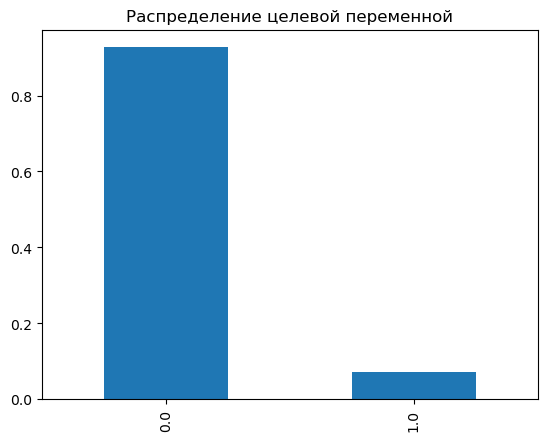

In [25]:
y = train_df['target']
(y.value_counts()/y.shape[0]).plot(kind='bar', title='Распределение целевой переменной');
y.value_counts()/y.shape

0.0    0.927671
1.0    0.072329
Name: target, dtype: float64

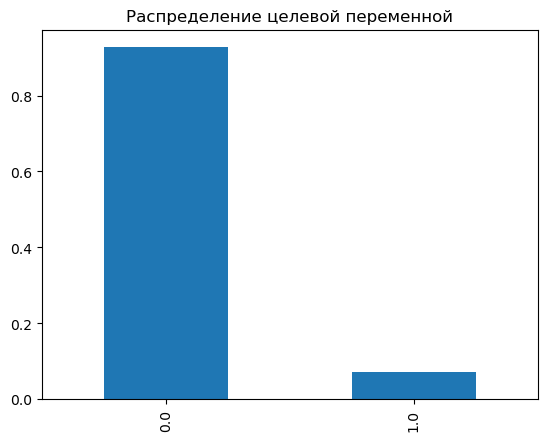

In [26]:
y = train_with_feats_df['target']
(y.value_counts()/y.shape[0]).plot(kind='bar', title='Распределение целевой переменной');
y.value_counts()/y.shape

Датасет сильно несбалансированный, примерно **13:1**
    
Посмотрим как целевая переменная распределялась по услугам:

In [27]:
train_df['vas_id'].value_counts().sort_index()

1.0    310175
2.0    249505
4.0     85756
5.0     94085
6.0     57878
7.0     15432
8.0     13350
9.0      5472
Name: vas_id, dtype: int64

In [28]:
vas_one = train_df.loc[(train_df['target']==1, 'vas_id') ].value_counts().sort_index()
vas_one

1.0     5664
2.0     4797
4.0    21765
5.0     1692
6.0    24704
7.0      213
8.0      347
9.0     1004
Name: vas_id, dtype: int64

In [29]:
vas_zero = train_df.loc[(train_df['target']==0, 'vas_id') ].value_counts().sort_index()
vas_zero

1.0    304511
2.0    244708
4.0     63991
5.0     92393
6.0     33174
7.0     15219
8.0     13003
9.0      4468
Name: vas_id, dtype: int64

Изобразим:

,0,1,conversion
1.0,304511,5664,0.018261
2.0,244708,4797,0.019226
4.0,63991,21765,0.253801
5.0,92393,1692,0.017984
6.0,33174,24704,0.426829
7.0,15219,213,0.013802
8.0,13003,347,0.025993
9.0,4468,1004,0.183480


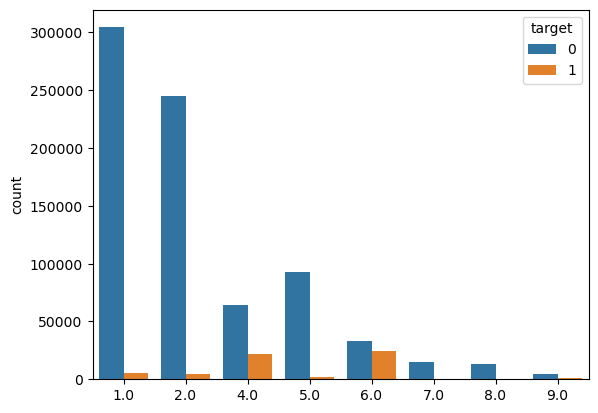

In [30]:
a = pd.DataFrame({'count': vas_zero})
a['target'] = 0
b = pd.DataFrame({'count': vas_one})
b['target'] = 1
c = pd.concat([a, b], axis=0)
d = pd.concat([vas_zero.rename('0'), vas_one.rename('1')], axis=1)
d['conversion'] = d['1']/d.sum(axis=1)
sns.barplot(data=c, x=c.index, y='count', hue='target');
d

* Самые предлагаемые услуги: 1, 2
* Самая высокая конверсия: 4, 6, 9
* Самая низкая конверсия: 1, 2, 5, 7, 8

### Анализ временного ряда

Посмотрим какое время охватывают предоставленные данные.

In [31]:
print(datetime.fromtimestamp(train_df['buy_time'].min()).strftime('%Y-%m-%d %H:%M:%S'))
print(datetime.fromtimestamp(train_df['buy_time'].max()).strftime('%Y-%m-%d %H:%M:%S'))

2018-07-09 00:00:00
2018-12-31 00:00:00


Построим график количества предложений каждой услуги на всем временном ряду:

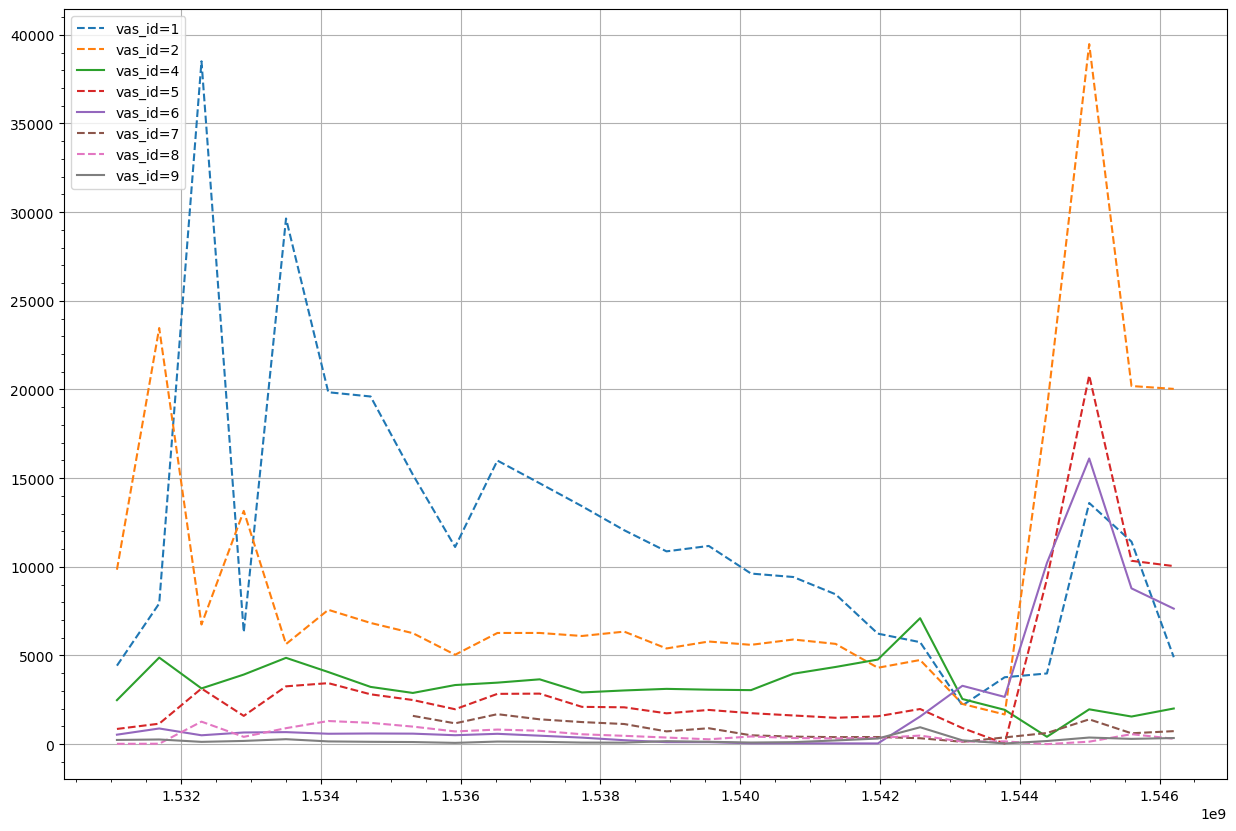

In [32]:
plt.figure(figsize=(15,10))
plt.plot(train_df.loc[(train_df['vas_id']==1, 'buy_time') ].value_counts().sort_index(), '--', label='vas_id=1')
plt.plot(train_df.loc[(train_df['vas_id']==2, 'buy_time') ].value_counts().sort_index(), '--', label='vas_id=2')
plt.plot(train_df.loc[(train_df['vas_id']==4, 'buy_time') ].value_counts().sort_index(), label='vas_id=4')
plt.plot(train_df.loc[(train_df['vas_id']==5, 'buy_time') ].value_counts().sort_index(), '--', label='vas_id=5')
plt.plot(train_df.loc[(train_df['vas_id']==6, 'buy_time') ].value_counts().sort_index(), label='vas_id=6')
plt.plot(train_df.loc[(train_df['vas_id']==7, 'buy_time') ].value_counts().sort_index(),'--', label='vas_id=7')
plt.plot(train_df.loc[(train_df['vas_id']==8, 'buy_time') ].value_counts().sort_index(),'--', label='vas_id=8')
plt.plot(train_df.loc[(train_df['vas_id']==9, 'buy_time') ].value_counts().sort_index(), label='vas_id=9')
plt.minorticks_on()
plt.grid(which='major')
plt.legend()
plt.show()

По графику видно, что активнее всего услуги предлагали в начале временного ряда и в конце, что соответствует середине (2018-07-09) и концу (2018-12-31) 2018 года. Скорее всего это связано с определенными рекламными компаниями. Непопулярные к предложению услуги отмечены пунктиром. Самые подключаемые - точками.

Думаю время при обучении все-таки учитывать не стоит.

## 2. Подготовка и отбор признаков <a class='anchor' id='data_preparation'>

- Определение типов признаков

In [33]:
# Разделим признаки и целевую переменную
features_drop = ['id', 'target']

X = train_with_feats_df.drop(features_drop, axis=1)
y = train_with_feats_df['target']

In [34]:
X.head()

,vas_id,0,1,2,3,4,5,6,7,8,...,243,244,245,246,247,248,249,250,251,252
0,8.0,-31.559971,327.360888,-45.500786,274.753202,-50.918246,253.64821,49.15382,195.883903,-1.835267,...,-845.373846,-613.770792,-20.996269,-37.630448,-28.747724,4.167111,7.305572,-12.175933,21.54386,0.0
1,4.0,547.270029,238.430888,533.329214,274.803202,527.911754,253.69821,-16.08618,-65.076097,-6.783660,...,-972.373846,-613.770792,-25.996269,-19.630448,-278.747724,-24.832889,-0.694428,-11.175933,-0.45614,0.0
2,1.0,-92.139971,-95.469112,-106.080786,-139.596798,-111.498246,-142.90179,-16.08618,-65.076097,-6.783660,...,-977.373846,-613.770792,-25.996269,-37.630448,-304.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,5.0,54.880029,12.970888,54.079214,-9.116798,48.661754,-30.22179,60.17382,87.453903,-6.783660,...,-977.373846,-613.770792,-25.996269,-18.630448,-133.747724,-14.832889,-0.694428,-1.175933,-0.45614,0.0
4,1.0,45.160029,295.240888,64.679214,344.283202,59.261754,323.17821,-16.08618,-65.076097,-6.783660,...,-965.373846,-612.770792,-22.996269,-32.630448,-127.747724,-4.832889,-0.694428,-12.175933,-0.45614,0.0


In [35]:
X.shape, y.shape

((860052, 254), (860052,))

254 признака и 860052 объекта

### Определение типов признаков

Все

In [36]:
X_nunique_feats = X.apply(lambda x: x.nunique(dropna=False))

In [37]:
f_all = set(X_nunique_feats.index.tolist())
len(f_all)

254

**Константные признаки**

In [38]:
f_const = set(X_nunique_feats[X_nunique_feats == 1].index.tolist())
len(f_const)

5

In [39]:
f_const

{'139', '203', '75', '81', '85'}

**Вещественные признаки**

In [40]:
f_numeric = (X.astype(int).sum() - X.sum()).abs()
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
len(f_numeric)

247

In [41]:
list(f_numeric)[:5]

['29', '7', '234', '147', '151']

In [42]:
f_other = f_all - (f_numeric | f_const)
len(f_other)

2

**Бинарные признаки**

In [43]:
f_binary = set(X.loc[:, f_other].columns[(
                      (X.loc[:, f_other].max() == 1) & \
                      (X.loc[:, f_other].min() == 0) & \
                      (X.loc[:, f_other].isnull().sum() == 0))])
len(f_binary)

0

In [44]:
f_other = f_other - f_binary
len(f_other)

2

In [45]:
f_other

{'252', 'vas_id'}

**Категориальные признаки**

In [46]:
f_categorical = set(X_nunique_feats.loc[f_other][X_nunique_feats.loc[f_other] <= 10].index.tolist())
f_numeric_extra = f_categorical

In [47]:
f_categorical

{'vas_id'}

In [48]:
f_other = f_other - f_categorical
len(f_other)

1

Нераспределенный признак:

In [49]:
X['252'].value_counts()

0.0       642435
1.0       217573
2.0            5
8.0            3
3.0            3
10.0           3
13.0           2
4.0            2
11.0           2
5.0            2
7.0            2
22.0           1
299.0          1
68.0           1
77.0           1
182.0          1
223.0          1
283.0          1
195.0          1
42.0           1
44.0           1
19.0           1
6.0            1
1743.0         1
16.0           1
36.0           1
24.0           1
251.0          1
18.0           1
84.0           1
284.0          1
Name: 252, dtype: int64

Видимо от него нужно избавиться. Почти все признаки вещественные.

## 3. Разбиение на train и test <a class='anchor' id='split'>


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X.drop('252', axis=1), y, test_size=0.33, shuffle=True, random_state=12)

## 4. Моделирование <a class='anchor' id='modeling'>


Обучение финальной модели

In [51]:
ctb = catb.CatBoostClassifier(silent = True, 
                              loss_function='Logloss',
                              eval_metric='Accuracy',
                              auto_class_weights=None,
                              random_state=12)

In [52]:
ctb.fit(X_train, y_train)

## 5. Оценка <a class='anchor' id='evaluation'>

Оценка качества финальной модели (расчет метрик)

In [53]:
y_test_raw_pred = ctb.predict(X_test, prediction_type='RawFormulaVal')
y_train_raw_pred = ctb.predict(X_train, prediction_type='RawFormulaVal')

In [54]:
probabilities_test = sigmoid(y_test_raw_pred)
probabilities_train = sigmoid(y_train_raw_pred)

In [55]:
thresholds = np.linspace(0, 1, 1001)
f1_list = []
for th in thresholds:
    f1 = f1_score(y_test, probabilities_test > th, average='macro')
    f1_list.append(f1)

In [56]:
ix = np.argmax(np.array(f1_list))
final_threshold = thresholds[ix]
final_threshold

0.254

In [57]:
get_classification_report(y_train, 
                          probabilities_train > final_threshold, 
                          y_test, 
                          probabilities_test > final_threshold)

TRAIN

              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95    534419
         1.0       0.42      0.68      0.52     41815

    accuracy                           0.91    576234
   macro avg       0.70      0.80      0.74    576234
weighted avg       0.93      0.91      0.92    576234

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94    263426
         1.0       0.35      0.57      0.44     20392

    accuracy                           0.89    283818
   macro avg       0.66      0.74      0.69    283818
weighted avg       0.92      0.89      0.91    283818



Сохраним лучшую модель

In [58]:
pickle.dump(ctb, open(MODEL_PATH, 'wb'))

## 6. Предсказание <a class='anchor' id='prediction'>

Делаем предсказание на тестовом датасете и записываем результат в файл как того требует задание.

In [59]:
feats_drop_list = ['id', '252']

#### Загрузка тестовых данных

In [60]:
test_df = pd.read_csv(RAW_TEST_DATASET_PATH)
features_df = dd.read_csv(RAW_FEATURES_DATASET_PATH, delimiter='\t')
te = test_df.drop(['Unnamed: 0', 'buy_time'], axis=1)
ft = features_df.drop(['Unnamed: 0', 'buy_time'], axis=1)

In [61]:
ft = ft.compute()
test_with_feats_df = te.merge(ft.drop_duplicates(subset=['id']), how='left')

In [73]:
te.shape, test_with_feats_df.shape

((71231, 2), (71231, 253))

In [63]:
# save
test_with_feats_df.to_csv(PREPARED_TEST_DATASET_PATH, index=False)

In [64]:
test_with_feats_df = test_with_feats_df.drop(feats_drop_list, axis=1)

In [65]:
test_with_feats_df.head()

,vas_id,0,1,2,3,4,5,6,7,8,...,242,243,244,245,246,247,248,249,250,251
0,2.0,-62.899971,-374.279112,-72.600786,-418.406798,-78.018246,-439.51179,17.81382,-31.176097,-6.78366,...,-17.295406,-970.373846,-613.770792,-25.996269,-37.630448,-258.747724,-25.832889,-0.694428,-12.175933,-0.45614
1,4.0,-96.799971,100.290888,-110.740786,140.903202,-116.158246,119.79821,-16.08618,-65.076097,-6.78366,...,-17.295406,-977.373846,-613.770792,-25.996269,-37.630448,-254.747724,-25.832889,-0.694428,-12.175933,-0.45614
2,2.0,-81.969971,-390.729112,-95.910786,-443.336798,-101.328246,-464.44179,-16.08618,-65.076097,-6.78366,...,-17.295406,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614
3,5.0,259.130029,-52.249112,245.189214,-104.856798,239.771754,-125.96179,-16.08618,-65.076097,-6.78366,...,-17.295406,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614
4,2.0,331.170029,590.890888,317.229214,538.283202,311.811754,522.25821,-16.08618,-65.076097,-6.78366,...,-17.295406,-651.373846,-612.770792,1.003731,-36.630448,38.252276,-12.832889,-0.694428,-12.175933,12.54386


**Загрузка модели**

In [74]:
loaded_model = pickle.load(open(MODEL_PATH, 'rb'))

**Предсказание**

In [75]:
final_threshold = 0.254

In [76]:
predictions = loaded_model.predict(test_with_feats_df, prediction_type='RawFormulaVal')
predictions = sigmoid(predictions)
final_predictions = predictions > final_threshold

In [77]:
test_df.shape, final_predictions.shape

((71231, 4), (71231,))

**Сохранение предсказания**

In [78]:
results = test_df.drop('Unnamed: 0', axis=1)
results['target'] = final_predictions.astype(int)
results.head()

,id,vas_id,buy_time,target
0,3130519,2.0,1548018000,0
1,2000860,4.0,1548018000,1
2,1099444,2.0,1546808400,0
3,1343255,5.0,1547413200,0
4,1277040,2.0,1546808400,0


In [79]:
results.shape

(71231, 4)

In [80]:
results.to_csv(TEST_PREDICTIONS_PATH, index=False)

---